### Weather API
Documentacion : 

se puede bajar un excel 
la latitud y longitud de nueva yor es un requisito de la api estas son_ 
long: -74.0059700 lat: 40.7142700

EN EL SIGUIENTE CODIGO CON AYUDA DE LA PAGINA QUE NOS PROPORCIONA LA API OPEN-METEO. DOS DATAFRAMES, POR HORA Y DIA.

EN EL DE HORAS, TRAEMOS POR HORA TEMPERATURA, LLUVIA, CAIDA DE NIEVE, PROFUNDIDAD DE NIEVE, SI ES DIA O NO
"hourly": ["temperature_2m", "rain", "snowfall", "snow_depth", "is_day"],

EN EL DE DIA TRAEMOS, LA MEDIA DE TEMPERATURA Y LA CANTIDAD DE LLUVIA.
"daily": ["temperature_2m_mean", "rain_sum"],

EN UN LAPSO DE TIMEPO DESDE 01/01/2010 HASTA 31/12/2022

In [1]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.71,
	"longitude": -74,
	"start_date": "2010-01-01",
	"end_date": "2022-12-31",
	"hourly": ["temperature_2m", "rain", "snowfall", "snow_depth", "is_day"],
	"daily": ["temperature_2m_mean", "rain_sum"],
	"timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_rain = hourly.Variables(1).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(2).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(3).ValuesAsNumpy()
hourly_is_day = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["is_day"] = hourly_is_day

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
daily_rain_sum = daily.Variables(1).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s"),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["rain_sum"] = daily_rain_sum

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)

Coordinates 40.738136291503906°E -74.04254150390625°N
Elevation 7.0 m asl
Timezone b'America/New_York' b'EST'
Timezone difference to GMT+0 -18000 s
                      date  temperature_2m  rain  snowfall  snow_depth  is_day
0      2010-01-01 05:00:00       -1.430500   0.1      0.28        0.04     0.0
1      2010-01-01 06:00:00       -0.980500   0.1      0.21        0.04     0.0
2      2010-01-01 07:00:00       -0.730500   0.1      0.14        0.04     0.0
3      2010-01-01 08:00:00       -0.830500   0.0      0.07        0.04     0.0
4      2010-01-01 09:00:00       -0.680500   0.0      0.00        0.04     0.0
...                    ...             ...   ...       ...         ...     ...
113947 2023-01-01 00:00:00        8.958500   0.4      0.00        0.00     0.0
113948 2023-01-01 01:00:00       11.108500   1.1      0.00        0.00     0.0
113949 2023-01-01 02:00:00       11.108500   0.8      0.00        0.00     0.0
113950 2023-01-01 03:00:00       11.158501   1.9      0.00    

### De la funcion que llama a la API surgen dos dataframes uno por dia 'daily_dataframe', y otro por horas 'hourly_dataframe'

In [2]:
hourly_dataframe.shape

(113952, 6)

In [13]:
# Pequeña cuenta para ver si trae los 10 años

365*24*12

105120

In [4]:
hourly_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            113952 non-null  datetime64[ns]
 1   temperature_2m  113952 non-null  float32       
 2   rain            113952 non-null  float32       
 3   snowfall        113952 non-null  float32       
 4   snow_depth      113952 non-null  float32       
 5   is_day          113952 non-null  float32       
dtypes: datetime64[ns](1), float32(5)
memory usage: 3.0 MB


In [5]:
# busqueda de nulos
hourly_dataframe.isnull().sum()

date              0
temperature_2m    0
rain              0
snowfall          0
snow_depth        0
is_day            0
dtype: int64

In [6]:
# busqueda de duplicados
hourly_dataframe.duplicated().sum()

0

In [7]:
hourly_dataframe.head()

,date,temperature_2m,rain,snowfall,snow_depth,is_day
0,2010-01-01 05:00:00,-1.4305,0.1,0.28,0.04,0.0
1,2010-01-01 06:00:00,-0.9805,0.1,0.21,0.04,0.0
2,2010-01-01 07:00:00,-0.7305,0.1,0.14,0.04,0.0
3,2010-01-01 08:00:00,-0.8305,0.0,0.07,0.04,0.0
4,2010-01-01 09:00:00,-0.6805,0.0,0.00,0.04,0.0


la variable is day me parecio interesante quizas para medir las horas de trafico diurno y nocturno. 

['is_day'] es dicotomica 0 noche 1 dia

In [8]:
# es 0 o 1
hourly_dataframe.is_day.unique()

array([0., 1.], dtype=float32)

In [9]:
hourly_dataframe.describe()

,date,temperature_2m,rain,snowfall,snow_depth,is_day
count,113952,113952.000000,113952.000000,113952.000000,113952.000000,113952.000000
mean,2016-07-02 04:30:00,12.354311,0.125441,0.008265,0.015441,0.507810
min,2010-01-01 05:00:00,-20.441500,0.000000,0.000000,0.000000,0.000000
25%,2013-04-02 04:45:00,4.269500,0.000000,0.000000,0.000000,0.000000
50%,2016-07-02 04:30:00,12.719500,0.000000,0.000000,0.000000,1.000000
75%,2019-10-02 04:15:00,20.869501,0.000000,0.000000,0.000000,1.000000
max,2023-01-01 04:00:00,38.769501,33.799999,4.340000,0.470000,1.000000
std,NaN,10.167228,0.588947,0.093745,0.055097,0.499941


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\PABLO\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\PABLO\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\PABLO\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\PABLO\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

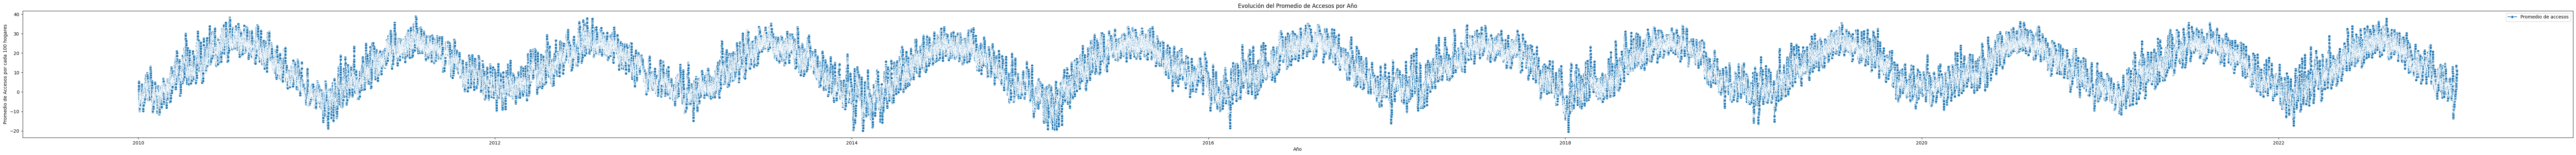

In [11]:

# Gráfico de línea de la evolución del promedio de accesos por año
plt.figure(figsize=(100, 5))
sns.lineplot(x=hourly_dataframe.date , y=hourly_dataframe.temperature_2m, marker='o', label='Promedio de accesos')
plt.title("Evolución del Promedio de Accesos por Año")
plt.xlabel("Año")
plt.ylabel("Promedio de Accesos por cada 100 hogares")
plt.show()


In [14]:
hourly_dataframe.to_excel('horas_nyc.xlsx')

### Por dataframe daily, por dias una media de temperatura y una de lluvia para saber si llovio ese dia o no

In [15]:
daily_dataframe.head()

,date,temperature_2m_mean,rain_sum
0,2010-01-01 05:00:00,0.702833,0.4
1,2010-01-02 05:00:00,-3.534667,0.0
2,2010-01-03 05:00:00,-7.280499,0.0
3,2010-01-04 05:00:00,-4.730500,0.0
4,2010-01-05 05:00:00,-4.382584,0.0
